# Face Generation
In this project, I'll use generative adversarial networks to generate new images of faces.
### Get the Data
I'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and I'm doing GANs in a project for the first time, I'll test my neural network on MNIST before CelebA.  Running the GANs on MNIST will allow me to see how well the model trains sooner.

In [1]:
data_dir = './data'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. Here's a view of the first number of examples.

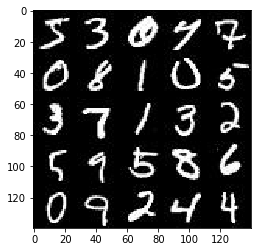

In [2]:
show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since I'm going to be generating faces, I won't need the annotations. Here's a view of the first number of examples.

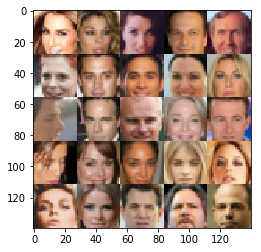

In [3]:
show_n_images = 25

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, the data will already be preprocessed. The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
I'll build the components necessary to build a GANs by implementing the following functions:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This just checks to make sure I have the correct version of TensorFlow and access to a GPU(my laptop does not so this will take me longer to train).

In [4]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


C:\Users\Sandoval\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


### Input
Here I'll implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Then return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    return inputs_real, inputs_z, learning_rate


tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Now I'll implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function will be able to reuse the variables in the neural network.  I'll use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x56
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x112
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
I'll implement `generator` to generate an image using `z`. This function will be able to reuse the variables in the neural network. I'll use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator',reuse=not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z,7*7*512)
        x1 = tf.reshape(x1,(-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='SAME')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2,x2)
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='SAME')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3,x3)
        
        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='SAME')
        output = tf.tanh(logits)
        
    return output

    
tests.test_generator(generator, tf)

Tests Passed


### Loss
I'll implement `model_loss` to build the GANs for training and calculate the loss.  The function will return a tuple of (discriminator loss, generator loss). I'll use the following functions previously implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]


    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt


tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
I'll use this function to show the current output of the generator during training. It will help determine how well the GANs is training.

In [10]:
import numpy as np

def show_generator_output(sess, n_images, z_input, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = z_input.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(z_input, out_channel_dim, False),
        feed_dict={z_input: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
I'll implement `train` to build and train the GANs using the following functions previously implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

I'll use the `show_generator_output` to show `generator` output while you train. I'll only print the 'generator' output every 100 batches since I don't have a GPU and running 'show_generator_output' for every batch will drastically increase training time and the size of the notebook.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model  
    # Model_inputs(image_width, image_height, image_channels, z_dim):
    print_every = 20
    show_every = 100
    
    input_real, input_z, ph_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3],  z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Train Model
                steps += 1
  
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, ph_learning_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, ph_learning_rate:learning_rate})
            
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, ph_learning_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, ph_learning_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)                

### MNIST
Now I'll test my GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits. I'll have to make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 1.2222
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 2.1000


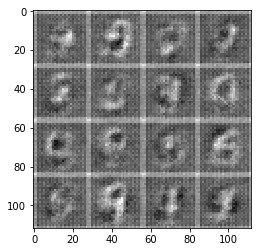

Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 1.2013
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.0081... Generator Loss: 0.8073
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 1.2667


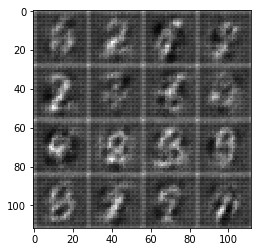

Epoch 1/2... Discriminator Loss: 0.8475... Generator Loss: 1.1454
Epoch 1/2... Discriminator Loss: 0.8038... Generator Loss: 0.9990
Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 1.3757
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 0.6736
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 2.1722


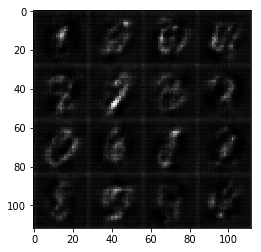

Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 2.2619
Epoch 1/2... Discriminator Loss: 0.6704... Generator Loss: 1.2154
Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 1.1653
Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 1.4205


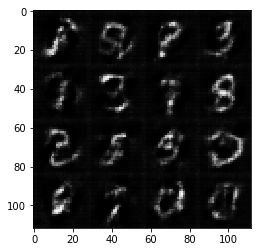

Epoch 1/2... Discriminator Loss: 0.9155... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 0.7028... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 0.6620... Generator Loss: 1.4121
Epoch 2/2... Discriminator Loss: 0.5965... Generator Loss: 1.3813
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.4343


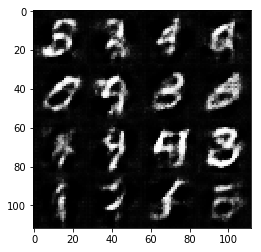

Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.4335
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 0.6938... Generator Loss: 1.6421
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.8696
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 0.7700


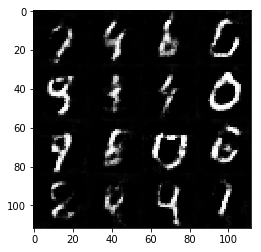

Epoch 2/2... Discriminator Loss: 0.7011... Generator Loss: 1.2520
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.8156
Epoch 2/2... Discriminator Loss: 0.9710... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.9249


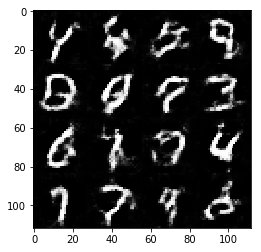

Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 1.2426
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 0.7468... Generator Loss: 1.3726
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 0.7985... Generator Loss: 1.3793


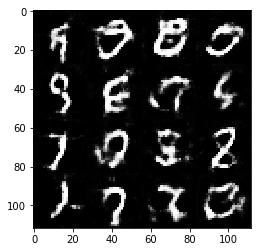

Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 1.8241
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 1.5621
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 0.8200... Generator Loss: 1.6274
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.7280


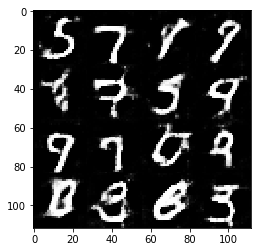

Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.4631


In [12]:
batch_size = 128
z_dim = 60
learning_rate = 0.0001
beta1 = 0.5
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Finally I'll run my GANs on CelebA.

Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 1.2692
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 1.0320


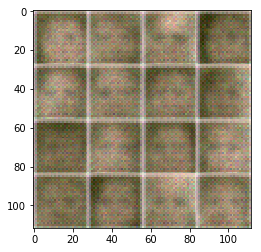

Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 0.8391


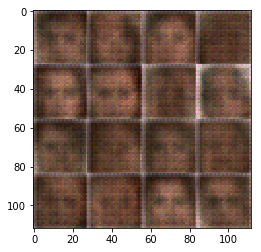

Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.5591
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.9068
Epoch 1/2... Discriminator Loss: 1.2665... Generator Loss: 0.5650
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 1.2223
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 0.8610


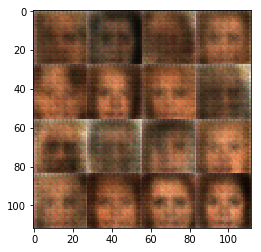

Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 1.8766
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.9387
Epoch 1/2... Discriminator Loss: 0.9556... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.4668


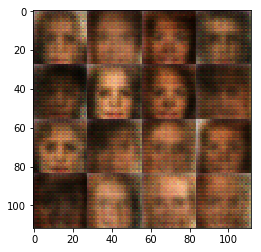

Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 1.0815
Epoch 1/2... Discriminator Loss: 1.6268... Generator Loss: 0.4032
Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 0.6662


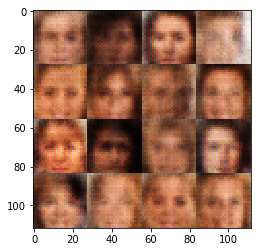

Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 1.1165
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 1.0600
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.8884
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.8639


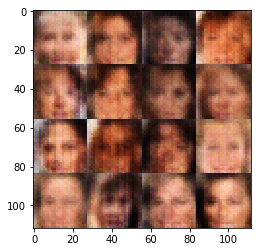

Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.9688
Epoch 1/2... Discriminator Loss: 1.3388... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.7322


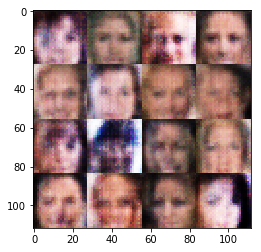

Epoch 1/2... Discriminator Loss: 1.1345... Generator Loss: 1.0835
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 1.0782
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.7940
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.9004


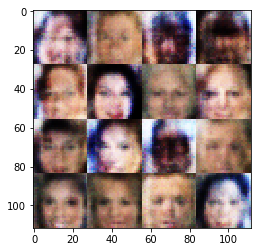

Epoch 1/2... Discriminator Loss: 1.3949... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.6330


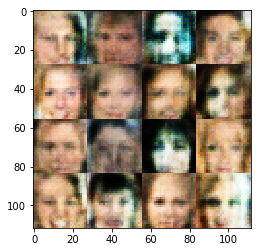

Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.8940


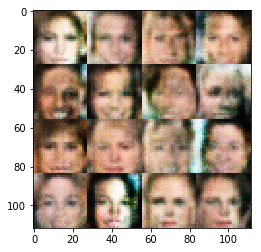

Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.3216... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.8356


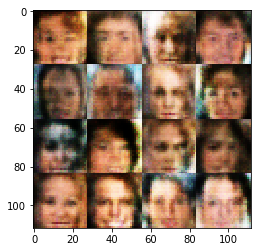

Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.8149
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.5209
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 1.2459


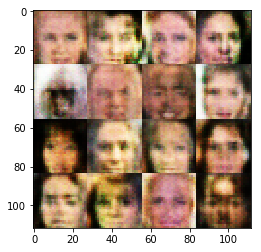

Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.9658
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.7013


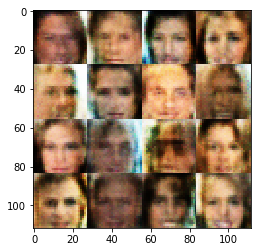

Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 0.3643
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 1.5822
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 1.9464
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.3890
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.5328


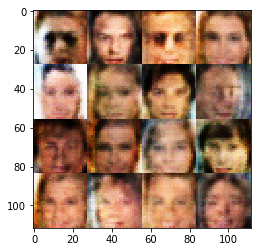

Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.7196
Epoch 1/2... Discriminator Loss: 0.8576... Generator Loss: 1.4704
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 1.1517


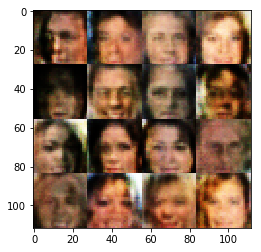

Epoch 1/2... Discriminator Loss: 1.9242... Generator Loss: 0.2276
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 0.7238
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 1.3748


KeyboardInterrupt: 

In [15]:
batch_size = 128
z_dim = 60
learning_rate = 0.0001
beta1 = 0.5
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

**NOTE:** I had to stop the training at this point since I don't have a GPU and training this much had taken me 15 hours. You can see the direction the images were headed, the same as the mnist one's which would be indistinguishable from non-generated faces!